# Loss Detector via NLP-based Complaints Analysis for BOA

## Table of Content
1. [Introduction](#intro)
2. [Objective](#obj)
3. [Data](#data)

    3.1 [Data Source](#datasource)
    
    3.2 [Exploratory Data Analysis](#eda)
    
4. [Modeling](#model)

    4.1 [Text Cleaning](#textclean)
    
    4.2 [Model Selection](#select)
    
5. [Conclusion](#conclusion)

## <a name="intro"></a>1. Introduction

Any complaint case closed with monetary relief means a loss to the company. Paying more attention and performing deeper analysis on these complaints, not only helps company to reduce/avoid the loss, but also provides indicators of potential risk management weakness or other deficiencies, such as violation of laws or rgulations, which can potentially result in larger loss through the Enforcement Actions by [Consumer Financial Protection Bureau (CFPB)](https://www.consumerfinance.gov/data-research/consumer-complaints/). For example, Press release on Dec 20, 2022, CFPB is ordering [Wells Fargo Bank](https://www.consumerfinance.gov/about-us/newsroom/cfpb-orders-wells-fargo-to-pay-37-billion-for-widespread-mismanagement-of-auto-loans-mortgages-and-deposit-accounts/) to pay more than 2 billion in redress to consumers and a 1.7 billion civil penalty for legal violations across several of its largest product lines. 

## <a name="obj"></a>2. Objective

Built classification models based on bank complaint narratives using NLP to identify whether a given consumer complaint requires monetary compensation.

## <a name="data"></a>3. Data

### <a name="datasource"></a>3.1 Data Source

Data are downloaded from Consumer Financial Protection Bureau Complaint Database

In [1]:
from helper import * 

In [2]:
dl = DataLoader()
df = dl.get_data('df_bank.csv', 'BANK OF AMERICA, NATIONAL ASSOCIATION')

### <a name="eda"></a>3.2 Exploratory Data Analysis

In [3]:
df = DataProcessor().transform(df)
df.head()

,date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,date_sent_to_company,company_response_to_consumer,timely_response?,consumer_disputed?,complaint_id,year,received_year,received_month,received_weekday,loss_binary
53,2022-12-06,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"My credit card company, Bank of America, has c...",Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",WA,98239.0,...,2022-12-06,Closed with monetary relief,Yes,NaN,6288250,2022,2022,12,1,1
54,2022-11-18,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,XXXX XXXX employee charged for luggage {$99.00...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,32867.0,...,2022-11-18,Closed with explanation,Yes,NaN,6221096,2022,2022,11,4,0
59,2022-11-18,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,Bank of America is reporting to the Credit age...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",SC,29926.0,...,2022-11-18,Closed with non-monetary relief,Yes,NaN,6220131,2022,2022,11,4,0
165,2022-11-04,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,I was scammed out of XXXX for a real estate re...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,94553.0,...,2022-11-04,Closed with monetary relief,Yes,NaN,6165440,2022,2022,11,4,1
167,2022-10-17,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I filed a fraud dispute claim XXXX with Bank o...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",NV,89141.0,...,2022-10-17,Closed with monetary relief,Yes,NaN,6093922,2022,2022,10,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30035 entries, 53 to 670540
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_received                 30035 non-null  datetime64[ns]
 1   product                       30035 non-null  object        
 2   sub-product                   28499 non-null  object        
 3   issue                         30035 non-null  object        
 4   sub-issue                     18629 non-null  object        
 5   consumer_complaint_narrative  30035 non-null  object        
 6   company_public_response       29627 non-null  object        
 7   company                       30035 non-null  object        
 8   state                         29833 non-null  object        
 9   zip_code                      29807 non-null  object        
 10  tags                          5412 non-null   object        
 11  consumer_consent_provided?

In [5]:
#missing value
df.isna().sum()

date_received                       0
product                             0
sub-product                      1536
issue                               0
sub-issue                       11406
consumer_complaint_narrative        0
company_public_response           408
company                             0
state                             202
zip_code                          228
tags                            24623
consumer_consent_provided?          0
submitted_via                       0
date_sent_to_company                0
company_response_to_consumer        0
timely_response?                    0
consumer_disputed?              22781
complaint_id                        0
year                                0
received_year                       0
received_month                      0
received_weekday                    0
loss_binary                         0
dtype: int64

In [6]:
print('Information about BOA bank dataset')
print('=============================================')    
print('Data contains', df.shape[0], 'complaints')        
print('Data time window: ', df.date_received.min(), ' to ',  df.date_received.max())
print('Duplicated record number: ', sum(df.duplicated()))
print('Missing value for complaints: ', df.consumer_complaint_narrative.isna().sum())
print('Missing value for company response to consumer: ', df.company_response_to_consumer.isna().sum())

Information about BOA bank dataset
Data contains 30035 complaints
Data time window:  2015-03-19 00:00:00  to  2022-12-06 00:00:00
Duplicated record number:  0
Missing value for complaints:  0
Missing value for company response to consumer:  0


Closed with explanation            0.668220
Closed with monetary relief        0.241318
Closed with non-monetary relief    0.085700
Closed                             0.003263
Untimely response                  0.001498
Name: company_response_to_consumer, dtype: float64


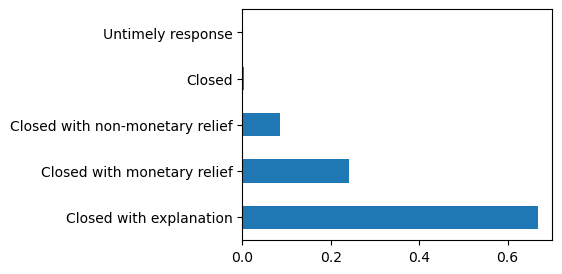

In [7]:
print(df.company_response_to_consumer.value_counts(normalize=True))
df.company_response_to_consumer.value_counts(normalize=True).plot(kind = 'barh', figsize = (4,3))
plt.show()

In [8]:
aaa =df.groupby(['date_received']).complaint_id.count().rename("complaint_counts").reset_index()
aaa.sort_values('complaint_counts', ascending=False)

,date_received,complaint_counts
1134,2018-04-28,46
2728,2022-09-20,36
2721,2022-09-13,34
2706,2022-08-29,34
2668,2022-07-22,31
...,...,...
1407,2019-01-29,1
1535,2019-06-09,1
1570,2019-07-14,1
1733,2019-12-25,1


In [9]:
def complaint_dailycounts():
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    ax =sns.countplot(x=aaa['complaint_counts'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'BOA Complaint Daily Counts Distribution')

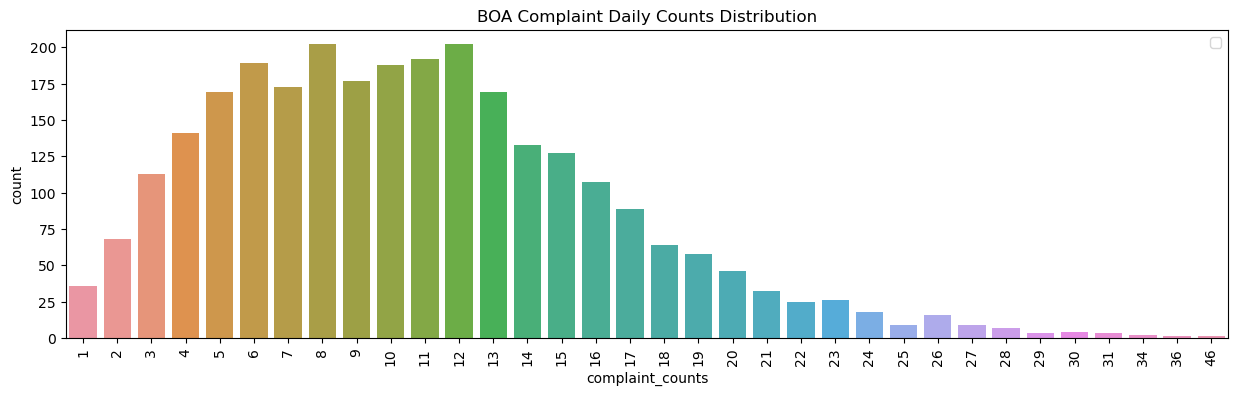

In [10]:
aaa.sort_values('complaint_counts',ascending=False)[:5]
complaint_dailycounts()
plt.title('BOA Complaint Daily Counts Distribution')

Text(0.5, 1.0, 'BOA response state distribution')

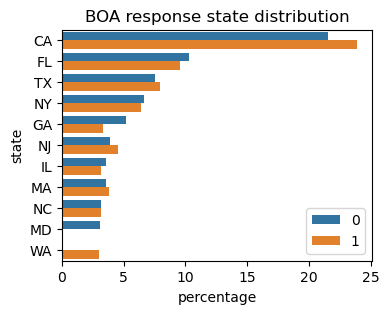

In [11]:
barplot_percentage(df, groupbycol='loss_binary', ycol='state', width=4, height=3, n=10)
plt.title('BOA response state distribution')

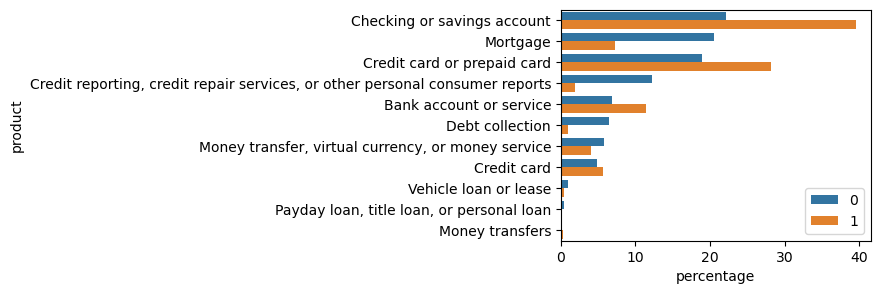

In [12]:
barplot_percentage(df, groupbycol='loss_binary', ycol='product', dfsource='all',width=4, height=3, n=10)

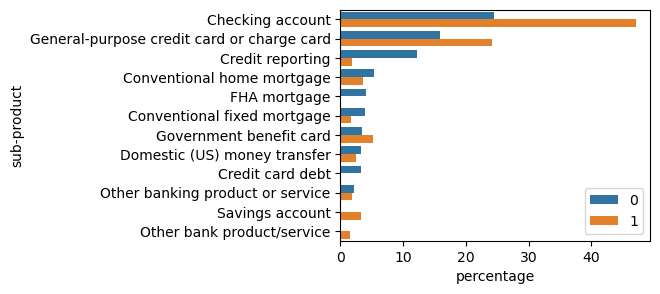

In [13]:
barplot_percentage(df, groupbycol='loss_binary', ycol='sub-product', dfsource='all',width=4, height=3, n=10)

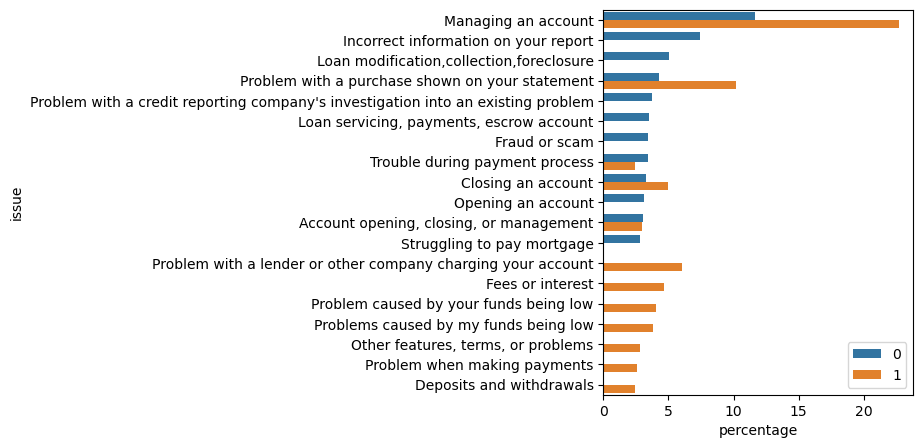

In [14]:
barplot_percentage(df, groupbycol='loss_binary', ycol='issue', width=4, height=5, n=12)

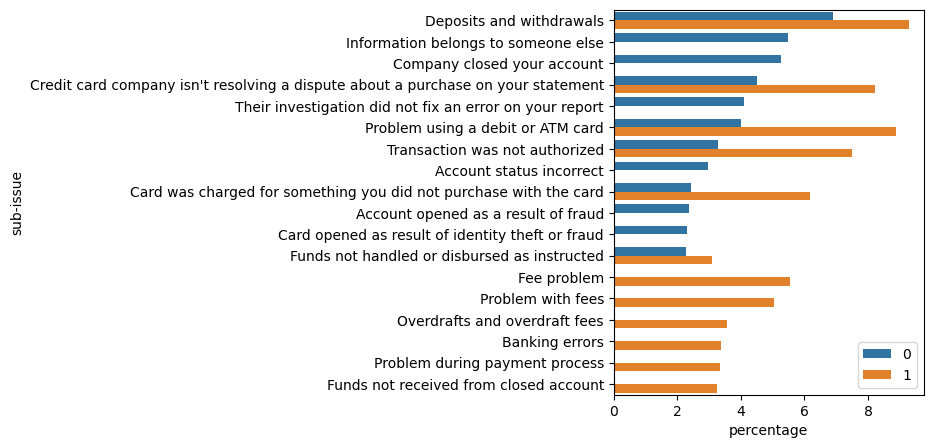

In [15]:
barplot_percentage(df, groupbycol='loss_binary', ycol='sub-issue', width=4, height=5, n=12)

<AxesSubplot: title={'center': 'BOA: Number of Complaints over Years'}, xlabel='year'>

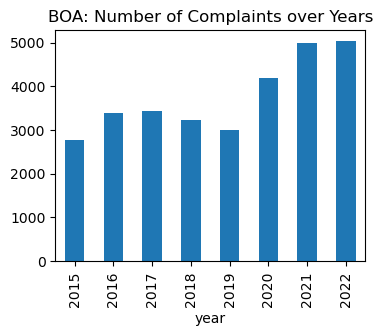

In [16]:
df.groupby('year')['complaint_id'].count().plot(kind='bar', title='BOA: Number of Complaints over Years',figsize = (4,3))

Text(0.5, 1.0, 'Monetary relief percentage over the years')

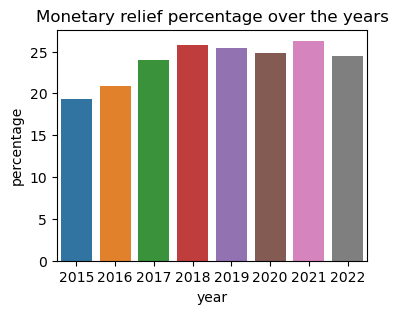

In [17]:
plt.figure(figsize=(4,3))
ratiodf = df.groupby('year')['loss_binary'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x='year', y="percentage",  data=ratiodf.query("loss_binary==1"))
plt.title('Monetary relief percentage over the years')

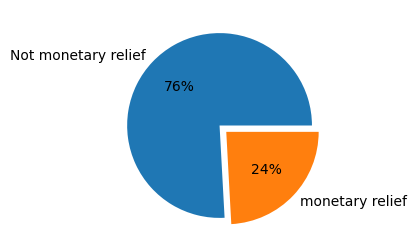

In [18]:
plt.figure(figsize=(4,3))
explode = (0, 0.1)
plt.pie(df.loss_binary.value_counts(normalize = True),autopct='%.0f%%', 
    labels=['Not monetary relief', 'monetary relief'], explode=explode)
plt.show()

## <a name="model"></a>4. Modeling

### <a name="textclean"></a>4.1 Text Cleaning

In [19]:
tp = TextProcessor()
text = df['consumer_complaint_narrative'].map(tp.clean_text)

In [20]:
X = text
y = df['loss_binary']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2023, stratify=y)

### <a name="select"></a>4.2 Model Selection

In [82]:
def nlpmodel(X_train, y_train, X_test, y_test, pipeline, model_name):
    model = pipeline.fit(X_train, y_train)
    print(f"number of words used in the model: {model.steps[-1][1].n_features_in_}")    
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('report for training set')
    print("====================================")
    print(classification_report(y_train, y_train_pred))
    print('report for testing set')
    print("====================================")
    print(classification_report(y_test, y_test_pred))
    
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    # plot ROC_curve
    ROC_curve(model_name,"train", y_train, y_train_pred_prob)
    ROC_curve(model_name, "test", y_test, y_test_pred_prob)
    return (model, y_test_pred_prob,y_test_pred)

## Naive Bayes

### BernoulliNB + BOW (bag of words)

number of words used in the model: 37584
report for training set
              precision    recall  f1-score   support

           0       0.89      0.79      0.83     15951
           1       0.51      0.68      0.58      5073

    accuracy                           0.76     21024
   macro avg       0.70      0.73      0.71     21024
weighted avg       0.79      0.76      0.77     21024

report for testing set
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      6836
           1       0.45      0.60      0.52      2175

    accuracy                           0.73      9011
   macro avg       0.66      0.68      0.66      9011
weighted avg       0.76      0.73      0.74      9011



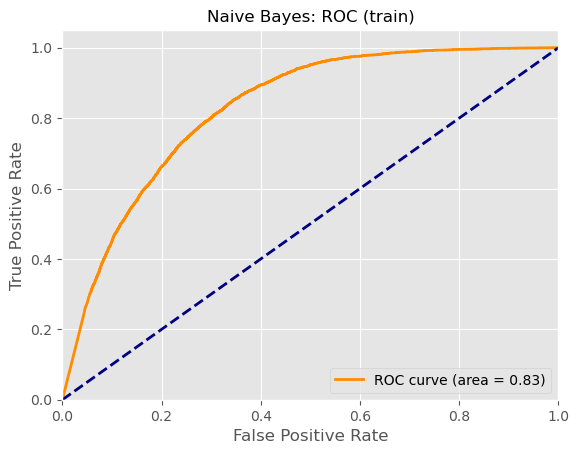

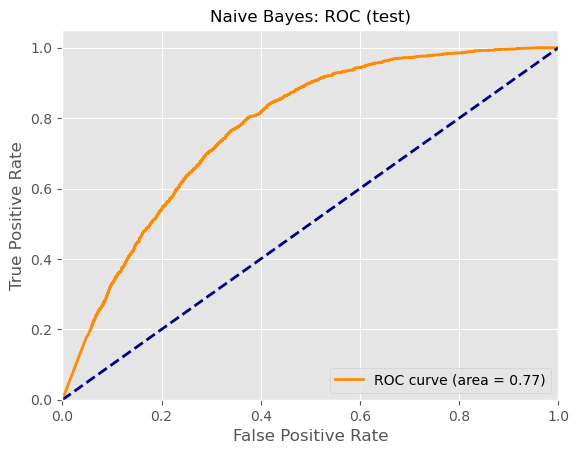

In [83]:
cv = CountVectorizer(
                     max_df=0.3,
                     min_df=10,
                     ngram_range=(1, 3),
                     binary=True
                    )
pipe = Pipeline([
                ('cv', cv), 
                ('nb', BernoulliNB())
                ])
model_nb, y_test_pred_prob_nb,y_test_pred_nb = nlpmodel(X_train, y_train, X_test, y_test, pipe, "Naive Bayes")

In [46]:
grams = [''] * len(model_nb['cv'].vocabulary_)
for k, v in model_nb['cv'].vocabulary_.items():
    grams[v] = k
negative_class_weight = list(zip(grams, model_nb['nb'].feature_log_prob_[0]))
negative_class_weight.sort(key=lambda x: x[1])
#negative_class_weight[-30:]

In [47]:
positive_class_weight = list(zip(grams, model_nb['nb'].feature_log_prob_[1]))
positive_class_weight.sort(key=lambda x: x[1])
#positive_class_weight[-30:]

In [48]:
def plot_wordcloud(grams, title):
    wc = WordCloud(
        width=800,
        height=400,
        random_state=100,
        max_words=500,
        background_color='white',
        relative_scaling=0  # relative_scaling=0 only word-ranks are considered
    )

    grams_dict = {x[0]:x[1] for x in grams}

    wc.generate_from_frequencies(grams_dict)

    plt.figure(figsize=(16, 8))
    plt.title(
        title,
        fontsize=16,
        color='Red',
        pad=40
    )
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=10)
    plt.show()

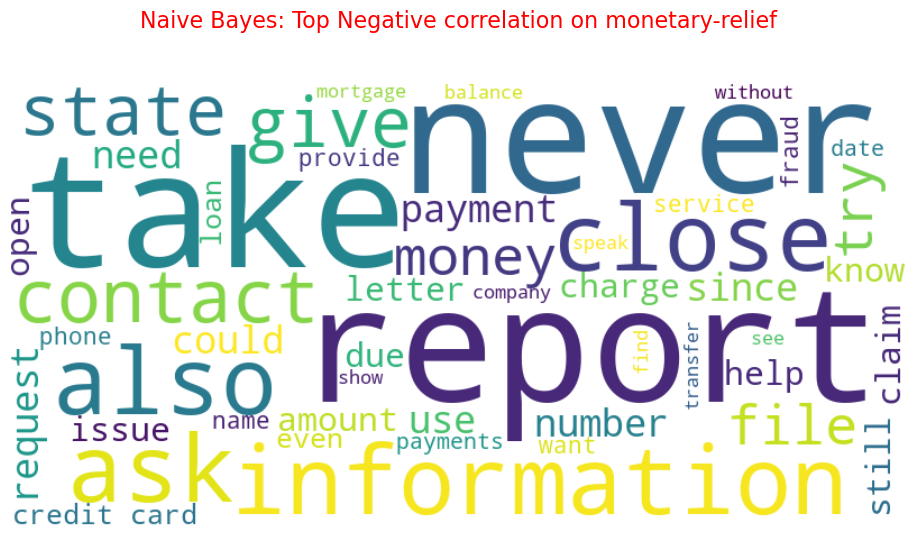

In [49]:
plot_wordcloud(negative_class_weight[-50:], 'Naive Bayes: Top Negative correlation on monetary-relief')

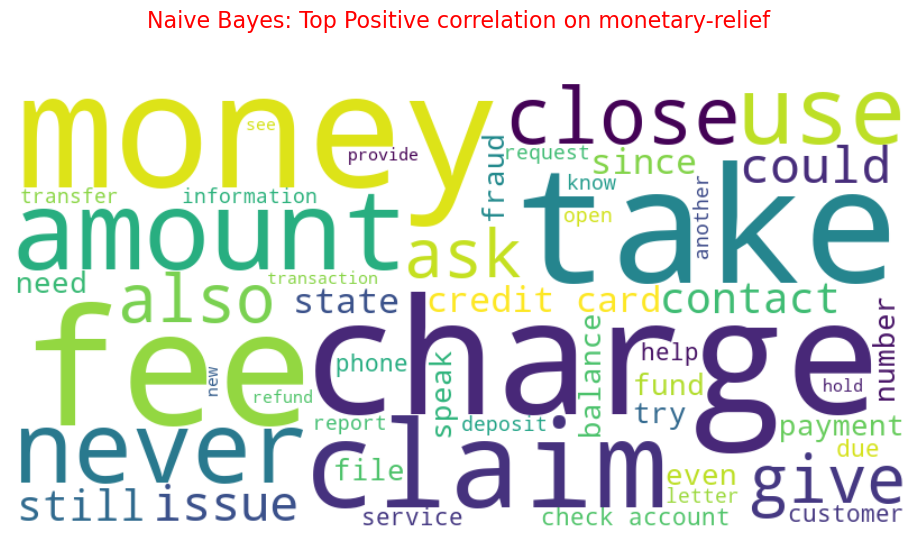

In [50]:
plot_wordcloud(positive_class_weight[-50:], 'Naive Bayes: Top Positive correlation on monetary-relief')

### MultinomialNB + tf-idf

number of words used in the model: 37584
report for training set
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     15951
           1       0.79      0.33      0.47      5073

    accuracy                           0.82     21024
   macro avg       0.81      0.65      0.68     21024
weighted avg       0.81      0.82      0.79     21024

report for testing set
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      6836
           1       0.62      0.20      0.30      2175

    accuracy                           0.78      9011
   macro avg       0.71      0.58      0.59      9011
weighted avg       0.75      0.78      0.73      9011



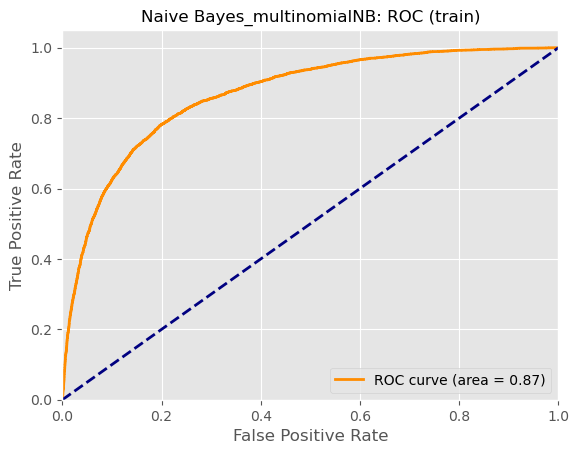

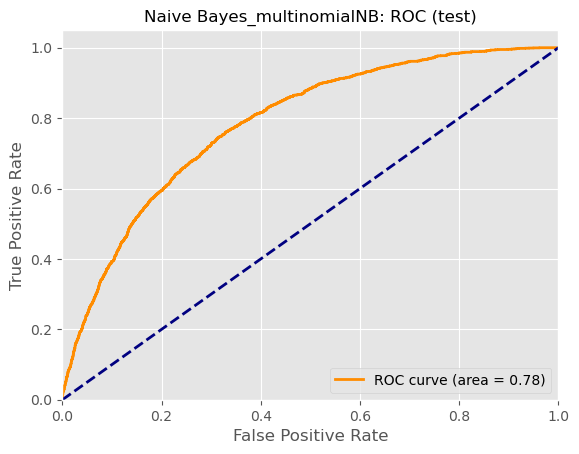

In [84]:
from sklearn.naive_bayes import MultinomialNB
# call tfidf with customerized settings
tfidf = TfidfVectorizer(
    lowercase=False,
    max_df=0.3,
    min_df=10,
    ngram_range=(1, 3)
)

# build the ML pipeline
pipe = Pipeline(
    [
        ('tfidf', tfidf),
        ('multiNB', MultinomialNB())
    ]
)
model_multi_nb,y_test_pred_prob_multi_nb,y_test_pred_multi_nb = nlpmodel(X_train, y_train, X_test, y_test, pipe, "Naive Bayes_multinomialNB")

In [70]:
grams = [''] * len(model_multi_nb['tfidf'].vocabulary_)
for k, v in model_multi_nb['tfidf'].vocabulary_.items():
    grams[v] = k
negative_class_weight = list(zip(grams, model_multi_nb['multiNB'].feature_log_prob_[0]))
negative_class_weight.sort(key=lambda x: x[1])
#negative_class_weight[-30:]

In [71]:
positive_class_weight = list(zip(grams, model_multi_nb['multiNB'].feature_log_prob_[1]))
positive_class_weight.sort(key=lambda x: x[1])
#positive_class_weight[-30:]

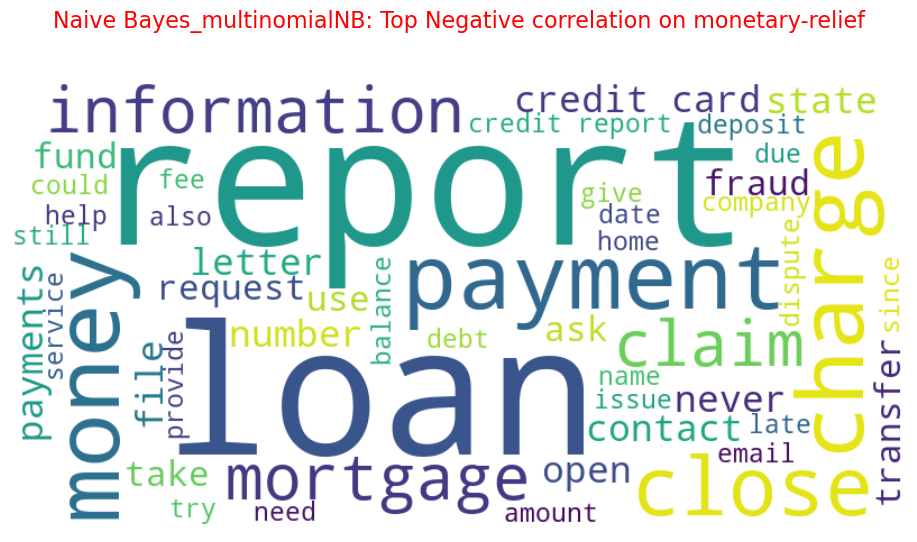

In [72]:
plot_wordcloud(negative_class_weight[-50:], 'Naive Bayes_multinomialNB: Top Negative correlation on monetary-relief')

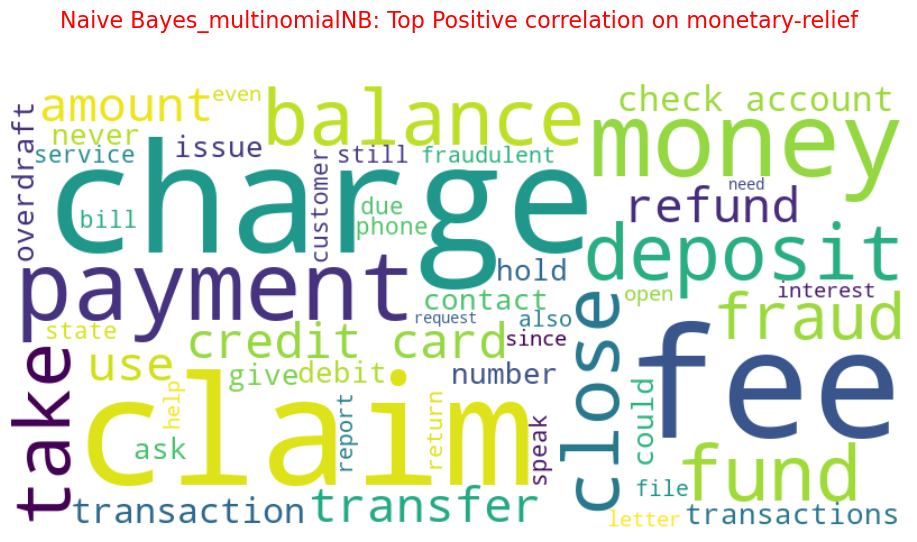

In [73]:
plot_wordcloud(positive_class_weight[-50:], 'Naive Bayes_multinomialNB: Top Positive correlation on monetary-relief')

## Logistic Regression

number of words used in the model: 87905
report for training set
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     15951
           1       0.64      0.92      0.75      5073

    accuracy                           0.85     21024
   macro avg       0.80      0.88      0.83     21024
weighted avg       0.89      0.85      0.86     21024

report for testing set
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      6836
           1       0.48      0.69      0.57      2175

    accuracy                           0.74      9011
   macro avg       0.68      0.73      0.69      9011
weighted avg       0.79      0.74      0.76      9011



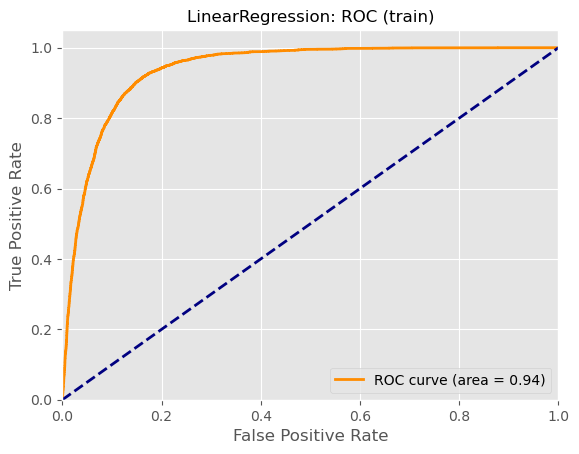

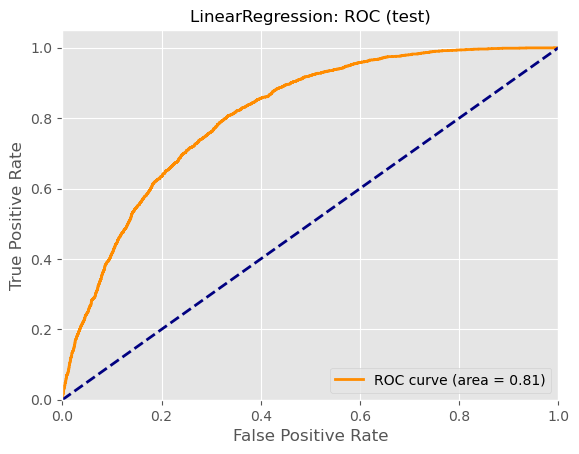

In [181]:
tfidf = TfidfVectorizer(
    lowercase=False,
    max_df=0.2,
    min_df=5,
    ngram_range=(1, 3)
)

pipe = Pipeline(
    [
        ('tfidf', tfidf),
        ('lg', LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1))
    ]
)
model_lg,y_test_pred_prob_lg,y_test_pred_lg = nlpmodel(X_train, y_train, X_test, y_test, pipe, "LinearRegression")

In [182]:
grams_lg = [""] * len(model_lg["tfidf"].vocabulary_)
for k, v in model_lg["tfidf"].vocabulary_.items():
    grams_lg[v] = k
gram_weight = list(zip(grams_lg, model_lg["lg"].coef_[0]))
gram_weight.sort(key=lambda x: x[1])
#gram_weight

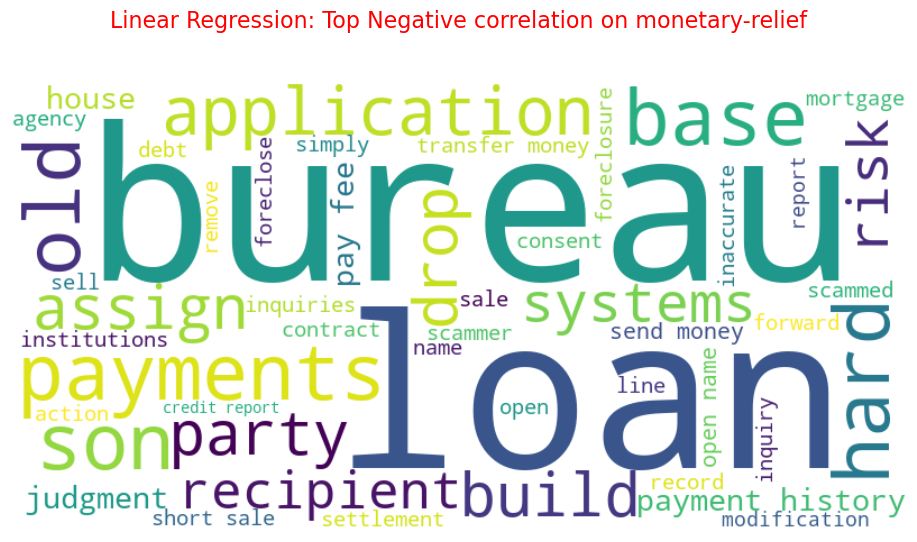

In [96]:
plot_wordcloud(gram_weight[:50], 'Linear Regression: Top Negative correlation on monetary-relief')

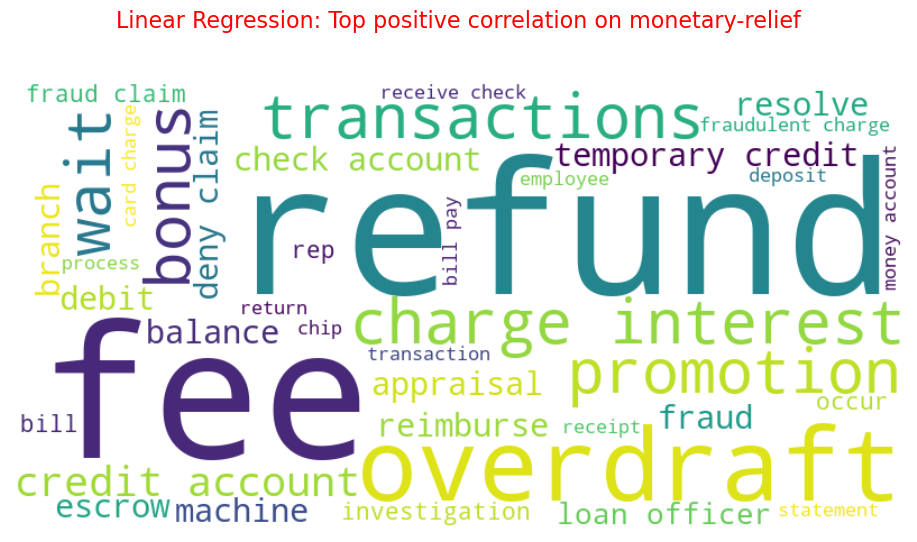

In [183]:
plot_wordcloud(gram_weight[-40:], 'Linear Regression: Top positive correlation on monetary-relief')

## Random Forest

number of words used in the model: 38871
report for training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15951
           1       1.00      1.00      1.00      5073

    accuracy                           1.00     21024
   macro avg       1.00      1.00      1.00     21024
weighted avg       1.00      1.00      1.00     21024

report for testing set
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      6836
           1       0.63      0.21      0.32      2175

    accuracy                           0.78      9011
   macro avg       0.71      0.59      0.59      9011
weighted avg       0.75      0.78      0.74      9011



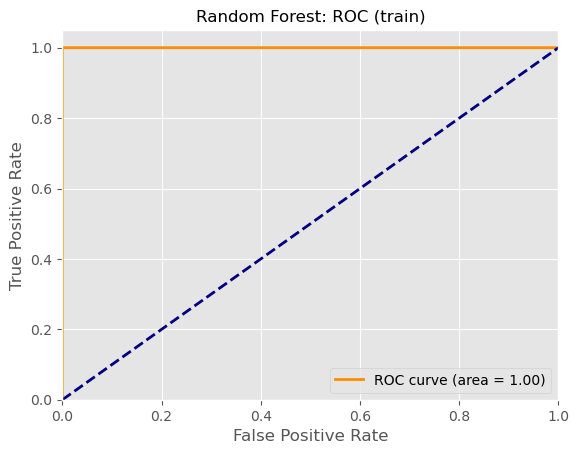

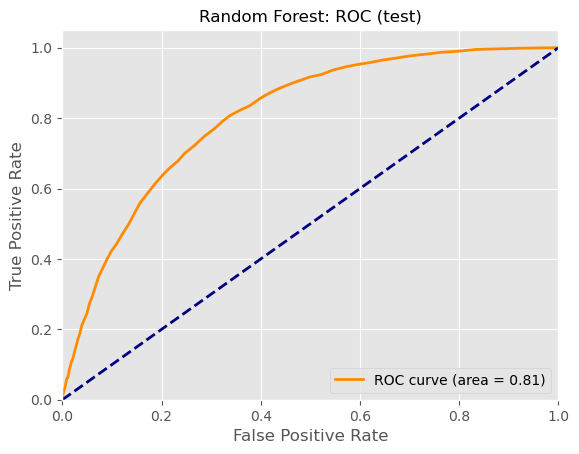

In [104]:
# call tfidf with customerized settings
tfidf = TfidfVectorizer(
    lowercase=False,
    max_df=0.5,
    min_df=10,
    ngram_range=(1, 3)
)

# build the ML pipeline
pipe = Pipeline(
    [
        ('tfidf', tfidf),
        ('rf', RandomForestClassifier(random_state = 2022, class_weight = 'balanced'))
    ]
)
model_rf,y_test_pred_prob_rf, y_test_pred_rf = nlpmodel(X_train, y_train, X_test, y_test, pipe, "Random Forest")

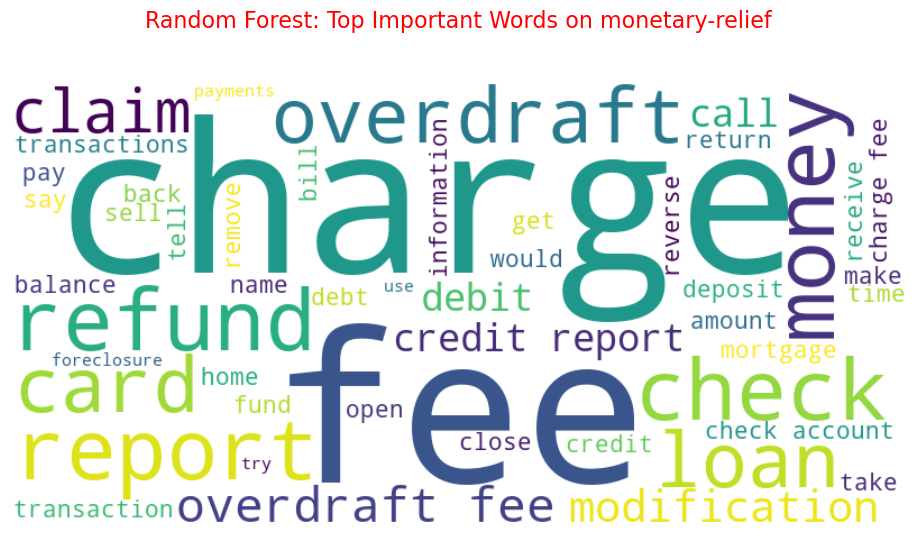

In [63]:
grams_rf = sort_grams(model_rf, 'rf')
plot_wordcloud(grams_rf[-50:], 'Random Forest: Top Important Words on monetary-relief')

In [74]:
def roc_metrics(y_true, y_pred_prob):
    fpr, tpr, thr = metrics.roc_curve(y_true, y_pred_prob)
    auc = metrics.auc(fpr, tpr)
    result = {}
    result['tpr'] = tpr
    result['fpr'] = fpr
    result['auc'] = auc
    return result

## compare models by ROC_AUC

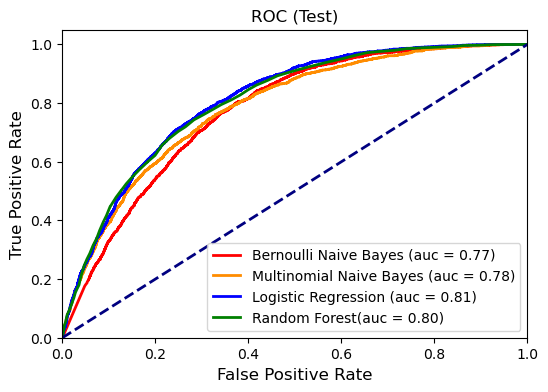

In [80]:
nb_roc = roc_metrics(y_test, y_test_pred_prob_nb)
mb_roc = roc_metrics(y_test, y_test_pred_prob_multi_nb)
lg_roc = roc_metrics(y_test, y_test_pred_prob_lg)
rf_roc = roc_metrics(y_test, y_test_pred_prob_rf)

plt.figure(figsize=(6,4))
lw = 2
plt.plot(nb_roc['fpr'], nb_roc['tpr'], color="red", lw=lw, label= f"Bernoulli Naive Bayes (auc = {nb_roc['auc']:0.2f})")
plt.plot(mb_roc['fpr'], mb_roc['tpr'], color="darkorange", lw=lw, label= f"Multinomial Naive Bayes (auc = {mb_roc['auc']:0.2f})")
plt.plot(lg_roc['fpr'], lg_roc['tpr'], color="blue", lw=lw, label= f"Logistic Regression (auc = {lg_roc['auc']:0.2f})")
plt.plot(rf_roc['fpr'], rf_roc['tpr'], color="green", lw=lw, label= f"Random Forest(auc = {rf_roc['auc']:0.2f})")

plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 12)
plt.title(f"ROC ({'Test'})", fontsize = 12)
plt.show()

## compare models by PR_AUC

Logistic Regression: f1=0.571 PR_auc=0.534
Random Forest: f1=0.302 PR_auc=0.536
Bernoulli Naive Bayes: f1=0.515 PR_auc=0.502
Multinomial Naive Bayes: f1=0.303 PR_auc=0.519


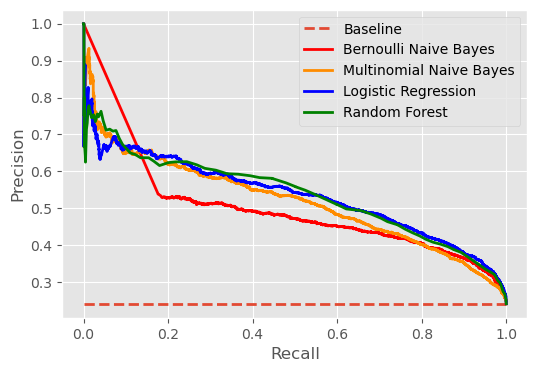

In [89]:
plt.figure(figsize=(6,4))
plt.style.use('ggplot')

lr_precision_1, lr_recall_1, thr_1 = metrics.precision_recall_curve(y_test, y_test_pred_prob_lg)
lr_f1_1, lr_auc_1 = metrics.f1_score(y_test, y_test_pred_lg), metrics.auc(lr_recall_1, lr_precision_1)
print('Logistic Regression: f1=%.3f PR_auc=%.3f' % (lr_f1_1, lr_auc_1))

lr_precision_2, lr_recall_2, thr_2 = metrics.precision_recall_curve(y_test, y_test_pred_prob_rf)
lr_f1_2, lr_auc_2 = metrics.f1_score(y_test, y_test_pred_rf), metrics.auc(lr_recall_2, lr_precision_2)
print('Random Forest: f1=%.3f PR_auc=%.3f' % (lr_f1_2, lr_auc_2))

lr_precision_3, lr_recall_3, thr_3 = metrics.precision_recall_curve(y_test, y_test_pred_prob_nb)
lr_f1_3, lr_auc_3 = metrics.f1_score(y_test, y_test_pred_nb), metrics.auc(lr_recall_3, lr_precision_3)
print('Bernoulli Naive Bayes: f1=%.3f PR_auc=%.3f' % (lr_f1_3, lr_auc_3))

lr_precision_4, lr_recall_4, thr_4 = metrics.precision_recall_curve(y_test, y_test_pred_prob_multi_nb)
lr_f1_4, lr_auc_4 = metrics.f1_score(y_test, y_test_pred_multi_nb), metrics.auc(lr_recall_4, lr_precision_4)
print('Multinomial Naive Bayes: f1=%.3f PR_auc=%.3f' % (lr_f1_4, lr_auc_4))


# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', linewidth = 2,label='Baseline')
plt.plot(lr_recall_3, lr_precision_3, color="red", linewidth = 2,label='Bernoulli Naive Bayes')
plt.plot(lr_recall_4, lr_precision_4, color= "darkorange", linewidth = 2,label='Multinomial Naive Bayes')
plt.plot(lr_recall_1, lr_precision_1, color="blue", linewidth = 2, label='Logistic Regression')
plt.plot(lr_recall_2, lr_precision_2, color= "green", linewidth = 2, label='Random Forest')


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.text(0.02, 0.2, 'PR_auc={0:.2f}'.format(lr_auc_1))

# show the legend
plt.legend()
# show the plot
plt.show()

### Choose threshold of probablity based on business need (see graph below):
- If loss avoidance is business's priority, we would choose a threshold with high recall while maintaining as high precision as possible.
- If business want to reduce human labor and want our prediction as accurate as possible, we want to reduce the number of false positive. We would choose a threshold with high precision while maintaining as high recall as possible.

In [91]:
def pr_threshold_curve(threshold, precision, recall, model_name):
    plt.style.use('ggplot')
    plt.plot(threshold, recall,label = 'recall', alpha = 0.8)
    plt.plot(threshold, precision,label = 'precision', alpha = 0.8)
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.title(f'{model_name}')
    plt.show()

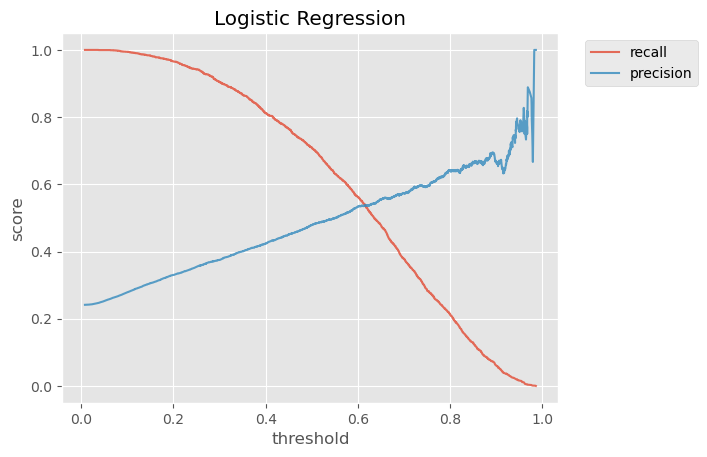

In [92]:
pr_threshold_curve(thr_1, lr_precision_1[1:], lr_recall_1[1:], 'Logistic Regression')

## <a name="conclusion"></a>5. Conclusion

* Based on ROC_AUC and PR_AUC scores, we choose Logistic Regression model as final model.
* By adjusting threshold to 0.4, Recall can reach 0.8, and presicion is 0.42.
* Got insights from Word Cloud, the monetary relief cases are related to different kinda of "fee"s, checking account ("overdraft"), and "credit card"

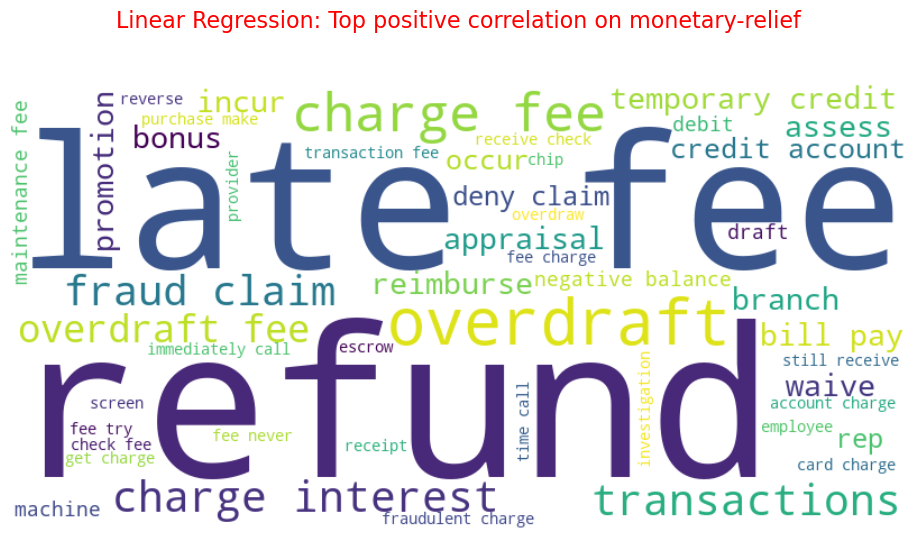

In [145]:
plot_wordcloud(gram_weight[-40:], 'Linear Regression: Top positive correlation on monetary-relief')